In [1]:
import pandas as pd

# Example dataframe
df = pd.read_csv('data/training_text_drg.csv')


def subsample_dataframe(df, label_column='CARD_ARRHYTHMIA', text_column='training_text'):
    # Filter positive and negative examples
    positive_df = df[df[label_column] == 1]
    negative_df = df[df[label_column] == 0]
    
    # Get the number of positive examples
    num_positive = len(positive_df)
    
    # Sample an equal number of negative examples
    negative_sample_df = negative_df.sample(n=num_positive, random_state=42)
    
    # Concatenate positive and negative samples
    balanced_df = pd.concat([positive_df, negative_sample_df])
    
    # Shuffle the resulting dataframe
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Subsample to include only the label and text columns
    subsampled_df = balanced_df[[label_column, text_column]]
    
    return subsampled_df

# Subsample the dataframe
subsampled_df = subsample_dataframe(df)
subsampled_df


CARD_ARRHYTHMIA                                      training_text
0                   0  Admission Type: EW EMER., Admission Location: ...
1                   1  Admission Type: URGENT, Admission Location: TR...
2                   0  Admission Type: EW EMER., Admission Location: ...
3                   1  Admission Type: EW EMER., Admission Location: ...
4                   0  Admission Type: EW EMER., Admission Location: ...
...               ...                                                ...
2341                0  Admission Type: DIRECT EMER., Admission Locati...
2342                1  Admission Type: EW EMER., Admission Location: ...
2343                1  Admission Type: EW EMER., Admission Location: ...
2344                0  Admission Type: URGENT, Admission Location: IN...
2345                1  Admission Type: DIRECT EMER., Admission Locati...

[2346 rows x 2 columns]

In [2]:
import re 

def preprocess_text(text):
    text = re.sub(r'\n', ' ', text)  # Replace new lines with white space
    text = re.sub(r'_+', '_', text)  # Replace repeating underscores with a single underscore
    text = re.sub(r'\s+', ' ', text)  # Replace repeating white spaces with a single white space
    return text.strip()

df['processed_text'] = df['training_text'].apply(lambda x: preprocess_text(x))

In [24]:
import tiktoken

def count_tokens(text, tokenizer):
    tokens = tokenizer.encode(text)
    return len(tokens)

def calculate_total_tokens(df, text_column='processed_text'):
    # Load the appropriate tokenizer
    tokenizer = tiktoken.get_encoding("cl100k_base")  # or use "p50k_base", "p50k_edit" as per your model
    
    total_tokens = df[text_column].apply(lambda x: count_tokens(x, tokenizer)).sum()
    return total_tokens

# Calculate total tokens for the dataframe
total_tokens = calculate_total_tokens(df, text_column="training_text")
print(f"Total number of tokens: {total_tokens}")

Total number of tokens: 53128942


In [3]:

tokenizer = tiktoken.get_encoding("cl100k_base") 
text = subsampled_df['training_text'].iloc[0]
# text = preprocess_text(text)
tokens = tokenizer.encode(text)
len(tokens)

NameError: name 'tiktoken' is not defined

In [7]:
unprocessed_tokens = 53128942
processed_tokens = 48482376

cost = (processed_tokens / 1e6) * 0.13 
cost

6.302708880000001

In [9]:
subsampled_df['CARD_ARRHYTHMIA'].value_counts()

CARD_ARRHYTHMIA
0    1173
1    1173
Name: count, dtype: int64

In [30]:
!pip install --upgrade openai


In [57]:
from openai import OpenAI
import os

client = OpenAI(
  api_key=api_key, 
)


def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding



In [58]:

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding


text = subsampled_df.iloc[0]['processed_text']

embedding = get_embedding(text)
embedding

[-0.014492020942270756,
 0.010730353184044361,
 0.028728049248456955,
 0.06809400767087936,
 -0.03891086205840111,
 0.04354717209935188,
 -0.01407958846539259,
 0.006762469187378883,
 -0.007800661027431488,
 -0.012436970137059689,
 -0.007274453993886709,
 0.01740749180316925,
 -0.02154603786766529,
 0.013716932386159897,
 0.02001008205115795,
 0.014819122850894928,
 0.031088870018720627,
 0.02009541355073452,
 -0.05202336981892586,
 0.03458743542432785,
 0.04661908373236656,
 -0.0003766556619666517,
 0.0377446748316288,
 -0.02578413486480713,
 -0.011868097819387913,
 -0.015046671032905579,
 -0.02355131134390831,
 -0.0018008362967520952,
 0.030036455020308495,
 -0.03037777915596962,
 0.06843533366918564,
 -0.01848834939301014,
 0.009414835833013058,
 -0.006808689795434475,
 -0.010773018933832645,
 0.030320892110466957,
 0.016468852758407593,
 0.014890231192111969,
 -0.017151499167084694,
 0.004657641518861055,
 0.019810976460576057,
 -0.05361621081829071,
 -0.024262402206659317,
 0.0004

In [4]:
import os
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
import tiktoken

client = OpenAI(api_key=api_key)

tokenizer = tiktoken.get_encoding("cl100k_base")

def get_embedding(text, model="text-embedding-3-small", max_tokens=8192):
    text = text.replace("\n", " ")
    tokens = tokenizer.encode(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        text = tokenizer.decode(tokens)  # Manually join tokens back to text
    return client.embeddings.create(input=[text], model=model).data[0].embedding

def process_dataframe_with_progress(df, text_column='processed_text', save_file='data/embeddings.csv', batch_size=100):
    if os.path.exists(save_file):
        # Load progress if file exists
        processed_df = pd.read_csv(save_file)
        processed_ids = set(processed_df['index'])
    else:
        # Create new file with columns if not exists
        processed_df = pd.DataFrame(columns=['index', 'embedding'])
        processed_ids = set()

    embeddings = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        if idx in processed_ids:
            print(f'Skipping {idx}', end='\r')
            continue  # Skip already processed rows
        text = row[text_column]
        try:
            embedding = get_embedding(text)
        except Exception as e:
            print(f'Error processing row {idx}: {e}')
            continue
        embeddings.append({'index': idx, 'embedding': embedding})

        if len(embeddings) >= batch_size:
            print(f'Writing batch on {idx}')
            temp_df = pd.DataFrame(embeddings)
            processed_df = pd.concat([processed_df, temp_df], ignore_index=True)
            processed_df.to_csv(save_file, index=False)
            embeddings = []  # Reset batch

    # Save any remaining embeddings
    if embeddings:
        temp_df = pd.DataFrame(embeddings)
        processed_df = pd.concat([processed_df, temp_df], ignore_index=True)
        processed_df.to_csv(save_file, index=False)

process_dataframe_with_progress(df, 'processed_text', 'data/embeddings.csv', 500)


Processing rows:  59%|█████▉    | 11512/19584 [00:00<00:00, 60026.34it/s]

Processing rows:  89%|████████▉ | 17515/19584 [00:00<00:00, 58250.03it/s]

Processing rows:  94%|█████████▍| 18492/19584 [02:20<02:23,  7.62it/s]   

Writing batch on 18499


Processing rows:  97%|█████████▋| 18995/19584 [04:31<02:21,  4.15it/s]

Writing batch on 18999


Processing rows: 100%|█████████▉| 19499/19584 [06:54<00:20,  4.13it/s]

Writing batch on 19499


Processing rows: 100%|██████████| 19584/19584 [07:24<00:00, 44.07it/s]


In [4]:
import os
import pandas as pd
import re
from tqdm import tqdm
from openai import AsyncOpenAI
import asyncio
import nest_asyncio
import tiktoken

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

api_key = os.getenv('OPENAI_API_KEY')

client = AsyncOpenAI(api_key=api_key)

async def get_embedding(text, model="text-embedding-3-small", max_tokens=8192):
    text = text.replace("\n", " ")
    tokens = tokenizer.encode(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        text = tokenizer.decode(tokens)  # Manually join tokens back to text
    response = await client.embeddings.create(input=[text], model=model)
    embedding = response.data[0].embedding
    return embedding



async def process_dataframe_with_progress(df, text_column='processed_text', save_file='data/embeddings.csv', batch_size=100):
    if os.path.exists(save_file):
        # Load progress if file exists
        processed_df = pd.read_csv(save_file)
        processed_ids = set(processed_df['index'])
    else:
        # Create new file with columns if not exists
        processed_df = pd.DataFrame(columns=['index', 'embedding'])
        processed_ids = set()

    embeddings = []
    tasks = []

    async def process_row(idx, row):
        if idx in processed_ids:
            return  # Skip already processed rows
        text = preprocess_text(row[text_column])
        embedding = await get_embedding(text)
        embeddings.append({'index': idx, 'embedding': embedding})

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        tasks.append(process_row(idx, row))
        if len(tasks) >= batch_size:
            await asyncio.gather(*tasks)
            temp_df = pd.DataFrame(embeddings)
            processed_df = pd.concat([processed_df, temp_df])
            processed_df.to_csv(save_file, index=False)
            embeddings.clear()  # Reset batch
            tasks.clear()  # Reset tasks

    # Process remaining tasks
    if tasks:
        await asyncio.gather(*tasks)
        temp_df = pd.DataFrame(embeddings)
        processed_df = pd.concat([processed_df, temp_df])
        processed_df.to_csv(save_file, index=False)


# asyncio.run(process_dataframe_with_progress(df))

await process_dataframe_with_progress(df)

Processing rows:   4%|▍         | 799/19584 [00:23<09:09, 34.21it/s]


CancelledError: 

In [5]:
embeddings_df = pd.read_csv('data/embeddings.csv')

# Ensure embeddings are loaded as list of lists
embeddings_df['embedding'] = embeddings_df['embedding'].apply(eval)

# Merge the embeddings with the training DataFrame
merge_df = df.merge(embeddings_df, left_index=True, right_on='index')


In [10]:
merge_df

hadm_id  CARD_ARRHYTHMIA  CELL_SKIN_INF  CELL_NO_MCC  CVA_INFARCT  \
0      29659838                0              0            0            0   
1      20897796                0              0            0            0   
2      21975601                0              0            0            0   
3      28994087                0              0            0            0   
4      26295318                0              0            0            0   
...         ...              ...            ...          ...          ...   
19579  25047276                0              0            0            0   
19580  20274882                0              0            0            0   
19581  28129567                0              0            0            0   
19582  27638769                0              0            0            0   
19583  26071774                0              0            0            1   

       PANCREAS_DIS  DIGEST_DIS_NO_MCC  HEART_FAILURE  HEART_SHOCK_MCC  \
0                 0                  0              1                0   
1                 0                  0              1                1   
2                 0                  0              0                0   
3                 0                  0              0                0   
4                 0                  0              1                1   
...             ...                ...            ...              ...   
19579             0                  0              0                0   
19580             0                  0              0                0   
19581             0                  0              0                0   
19582             0                  0              0                0   
19583             0                  0              0                0   

       KIDNEY_UTI  ...  GASTRO_NAUSEA  PNEUMONIA_OTHER  PCI_NO_AMI  PSYCHOSES  \
0               0  ...              0                0           0          0   
1               0  ...              0                0           0          0   
2               0  ...              0                0           1          0   
3               0  ...              0                1           0          0   
4               0  ...              0                0           0          0   
...           ...  ...            ...              ...         ...        ...   
19579           0  ...              0                0           0          0   
19580           0  ...              0                0           0          0   
19581           0  ...              0                0           1          0   
19582           0  ...              0                1           0          0   
19583           0  ...              0                0           0          0   

       SEPTICEMIA  SYNCOPE                                      training_text  \
0               0        0  Admission Type: EW EMER., Admission Location: ...   
1               0        0  Admission Type: OBSERVATION ADMIT, Admission L...   
2               0        0  Admission Type: EW EMER., Admission Location: ...   
3               0        0  Admission Type: EW EMER., Admission Location: ...   
4               0        0  Admission Type: URGENT, Admission Location: TR...   
...           ...      ...                                                ...   
19579           0        0  Admission Type: SURGICAL SAME DAY ADMISSION, A...   
19580           0        0  Admission Type: OBSERVATION ADMIT, Admission L...   
19581           0        0  Admission Type: URGENT, Admission Location: PH...   
19582           0        0  Admission Type: EW EMER., Admission Location: ...   
19583           0        0  Admission Type: EW EMER., Admission Location: ...   

                                          processed_text  index  \
0      Admission Type: EW EMER., Admission Location: ...      0   
1      Admission Type: OBSERVATION ADMIT, Admission L...      1   
2      Admission Type: EW EMER., Admission Loca

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

# List of class columns
class_columns = [
    'CARD_ARRHYTHMIA', 'CELL_SKIN_INF', 'CELL_NO_MCC', 
    'CVA_INFARCT', 'PANCREAS_DIS', 'DIGEST_DIS_NO_MCC', 
    'HEART_FAILURE', 'HEART_SHOCK_MCC', 'KIDNEY_UTI', 
    'JOINT_REPLACE_NO_MCC', 'DIGEST_DIS_OTHER', 'GASTRO_NAUSEA', 
    'PNEUMONIA_OTHER', 'PCI_NO_AMI', 'PSYCHOSES', 
    'SEPTICEMIA', 'SYNCOPE'
]


# Prepare the data
X = pd.DataFrame(merge_df['embedding'].to_list())
y = merge_df[class_columns]
y 


CARD_ARRHYTHMIA  CELL_SKIN_INF  CELL_NO_MCC  CVA_INFARCT  PANCREAS_DIS  \
0                    0              0            0            0             0   
1                    0              0            0            0             0   
2                    0              0            0            0             0   
3                    0              0            0            0             0   
4                    0              0            0            0             0   
...                ...            ...          ...          ...           ...   
19579                0              0            0            0             0   
19580                0              0            0            0             0   
19581                0              0            0            0             0   
19582                0              0            0            0             0   
19583                0              0            0            1             0   

       DIGEST_DIS_NO_MCC  HEART_FAILURE  HEART_SHOCK_MCC  KIDNEY_UTI  \
0                      0              1                0           0   
1                      0              1                1           0   
2                      0              0                0           0   
3                      0              0                0           0   
4                      0              1                1           0   
...                  ...            ...              ...         ...   
19579                  0              0                0           0   
19580                  0              0                0           0   
19581                  0              0                0           0   
19582                  0              0                0           0   
19583                  0              0                0           0   

       JOINT_REPLACE_NO_MCC  DIGEST_DIS_OTHER  GASTRO_NAUSEA  PNEUMONIA_OTHER  \
0                         0                 0              0                0   
1                         0                 0              0                0   
2                         0                 0              0                0   
3                         0                 0              0                1   
4                         0                 0              0                0   
...                     ...               ...            ...              ...   
19579                     1                 0              0                0   
19580                     0                 1              0                0   
19581                     0                 0              0                0   
19582                     0                 0              0                1   
19583                     0                 0              0                0   

       PCI_NO_AMI  PSYCHOSES  SEPTICEMIA  SYNCOPE  
0               0          0           0        0  
1               0          0           0        0  
2               1          0           0        0  
3               0          0           0        0  
4               0          0           0        0  
...           ...        ...         ...      ...  
19579           0          0           0        0  
19580           0          0           0        0  
19581           1          0           0        0  
19582           0          0           0        0  
19583           0          0           0        0  

[19584 rows x 17 columns]

In [14]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=5000))
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_columns))

Accuracy: 0.5351033954557058
Classification Report:
                      precision    recall  f1-score   support

     CARD_ARRHYTHMIA       0.85      0.49      0.62       230
       CELL_SKIN_INF       0.97      0.88      0.92       415
         CELL_NO_MCC       0.88      0.84      0.86       361
         CVA_INFARCT       0.96      0.86      0.90       222
        PANCREAS_DIS       0.91      0.73      0.81       249
   DIGEST_DIS_NO_MCC       0.78      0.61      0.68       436
       HEART_FAILURE       0.84      0.71      0.77       457
     HEART_SHOCK_MCC       0.65      0.25      0.36       313
          KIDNEY_UTI       0.86      0.49      0.63       251
JOINT_REPLACE_NO_MCC       1.00      0.97      0.98       237
    DIGEST_DIS_OTHER       0.72      0.36      0.48       250
       GASTRO_NAUSEA       0.75      0.40      0.52       286
     PNEUMONIA_OTHER       0.86      0.45      0.59       250
          PCI_NO_AMI       0.92      0.63      0.75       179
           PSYCHO

/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Define the hyperparameter grid
param_grid = {
    'estimator__C': [0.1, 1, 10],          # Inverse of regularization strength
    'estimator__penalty': ['l1', 'l2'],    # Norm used in penalization
    'estimator__solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Initialize the classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Initialize GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_columns))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear; total time=  13.6s
[CV] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear; total time=  14.0s
[CV] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear; total time=  14.0s
[CV] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear; total time=  14.1s
[CV] END estimator__C=0.1, estimator__penalty=l1, estimator__solver=liblinear; total time=  14.1s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=liblinear; total time=  20.0s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=liblinear; total time=  20.1s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=liblinear; total time=  20.2s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=liblinear; total time=  20.3s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimat

/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga; total time=  33.9s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga; total time=  33.9s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga; total time=  34.4s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga; total time=  34.6s
[CV] END estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga; total time=  34.3s
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  43.3s
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  46.5s
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  46.2s
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  44.4s
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  44.5s
[CV] END estimator__C=0.1, estimator__penalty=l1, estim

/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=saga; total time=34.9min
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=saga; total time=34.9min
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=saga; total time=35.0min
[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=saga; total time=35.1min


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END estimator__C=1, estimator__penalty=l1, estimator__solver=saga; total time=35.4min
[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear; total time=  40.8s


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear; total time=  40.9s
[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear; total time=  40.2s
[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear; total time=  40.4s


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear; total time=  39.3s


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=saga; total time= 2.4min
[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=saga; total time= 2.4min


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=saga; total time= 2.3min
[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=saga; total time= 2.3min
[CV] END estimator__C=10, estimator__penalty=l2, estimator__solver=saga; total time= 2.3min


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

KeyboardInterrupt: 

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

merge_df['embedding_np'] = merge_df['embedding'].apply(lambda x: np.array(x))
embeddings = np.vstack(merge_df['embedding_np'].values)

# List of class columns
class_columns = [
    'CARD_ARRHYTHMIA', 'CELL_SKIN_INF', 'CELL_NO_MCC', 
    'CVA_INFARCT', 'PANCREAS_DIS', 'DIGEST_DIS_NO_MCC', 
    'HEART_FAILURE', 'HEART_SHOCK_MCC', 'KIDNEY_UTI', 
    'JOINT_REPLACE_NO_MCC', 'DIGEST_DIS_OTHER', 'GASTRO_NAUSEA', 
    'PNEUMONIA_OTHER', 'PCI_NO_AMI', 'PSYCHOSES', 
    'SEPTICEMIA', 'SYNCOPE'
]


diagnosis_columns = merge_df[class_columns]


In [25]:
# Standardize the embeddings
scaler = StandardScaler()
embeddings_standardized = scaler.fit_transform(embeddings)

In [26]:
# Perform PCA
pca = PCA(n_components=4)  # Adjust the number of components as needed
principal_components = pca.fit_transform(embeddings_standardized)

In [28]:
# Create a DataFrame with the principal components and diagnosis columns
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df

PC1        PC2        PC3        PC4
0     -14.896453   1.314020  -9.926622  -4.580974
1     -15.960413   2.544476  -9.003546  -2.930602
2      -9.657478   6.849003  -8.973425   3.093182
3      -6.229114  -5.167224  -7.051514   0.851113
4     -12.761310  -0.497013  -9.817281  -2.107943
...          ...        ...        ...        ...
19579  17.588370  14.133746  -2.683109 -14.122080
19580  -2.721700  -7.355126  -3.983648  11.379993
19581  -6.731756  18.603361  -7.263253   9.217615
19582  -3.332720  -7.302659  11.781829  -1.396413
19583  -1.580333  11.622236  17.623506  13.807767

[19584 rows x 4 columns]

In [31]:
pca_df = pd.concat([pca_df, diagnosis_columns.reset_index(drop=True)], axis=1)


In [32]:
pca_df

PC1        PC2        PC3        PC4  CARD_ARRHYTHMIA  \
0     -14.896453   1.314020  -9.926622  -4.580974                0   
1     -15.960413   2.544476  -9.003546  -2.930602                0   
2      -9.657478   6.849003  -8.973425   3.093182                0   
3      -6.229114  -5.167224  -7.051514   0.851113                0   
4     -12.761310  -0.497013  -9.817281  -2.107943                0   
...          ...        ...        ...        ...              ...   
19579  17.588370  14.133746  -2.683109 -14.122080                0   
19580  -2.721700  -7.355126  -3.983648  11.379993                0   
19581  -6.731756  18.603361  -7.263253   9.217615                0   
19582  -3.332720  -7.302659  11.781829  -1.396413                0   
19583  -1.580333  11.622236  17.623506  13.807767                0   

       CELL_SKIN_INF  CELL_NO_MCC  CVA_INFARCT  PANCREAS_DIS  \
0                  0            0            0             0   
1                  0            0            0             0   
2                  0            0            0             0   
3                  0            0            0             0   
4                  0            0            0             0   
...              ...          ...          ...           ...   
19579              0            0            0             0   
19580              0            0            0             0   
19581              0            0            0             0   
19582              0            0            0             0   
19583              0            0            1             0   

       DIGEST_DIS_NO_MCC  ...  HEART_SHOCK_MCC  KIDNEY_UTI  \
0                      0  ...                0           0   
1                      0  ...                1           0   
2                      0  ...                0           0   
3                      0  ...                0           0   
4                      0  ...                1           0   
...                  ...  ...              ...         ...   
19579                  0  ...                0           0   
19580                  0  ...                0           0   
19581                  0  ...                0           0   
19582                  0  ...                0           0   
19583                  0  ...                0           0   

       JOINT_REPLACE_NO_MCC  DIGEST_DIS_OTHER  GASTRO_NAUSEA  PNEUMONIA_OTHER  \
0                         0                 0              0                0   
1                         0                 0              0                0   
2                         0                 0              0                0   
3                         0                 0              0                1   
4                         0                 0              0                0   
...                     ...               ...            ...              ...   
19579                     1                 0              0                0   
19580                     0                 1              0                0   
19581                     0                 0              0                0   
19582                     0                 0              0                1   
19583                     0                 0              0                0   

       PCI_NO_AMI  PSYCHOSES  SEPTICEMIA  SYNCOPE  
0               0          0           0        0  
1               0          0           0        0  
2               1          0           0        0  
3               0          0           0        0  
4               0          0           0        0  
...           ...        ...         ...      ...  
19579           0          0           0        0  
19580           0          0           0        0  
19581           1          0           0        0  
19582           0          0           0        0  
19583           0          0           0        0  

[19584 rows x 21 columns]

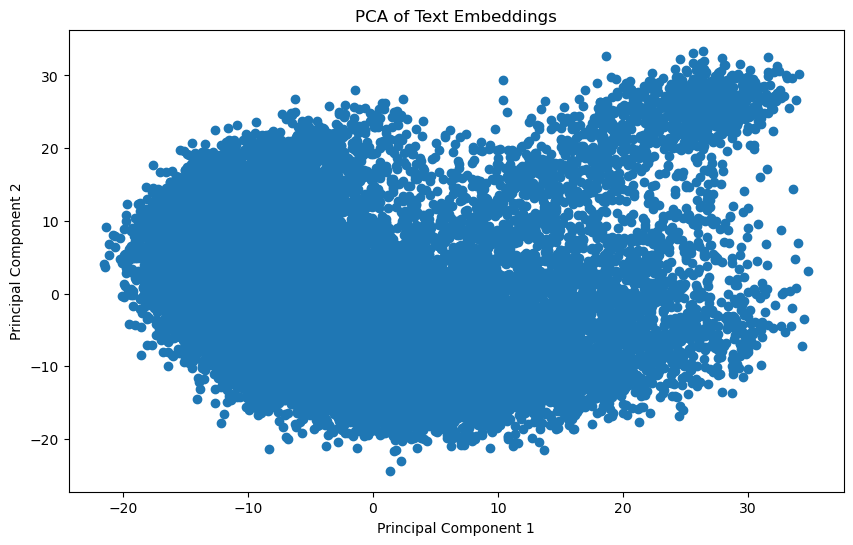

In [33]:
# Visualize the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Text Embeddings')
plt.show()

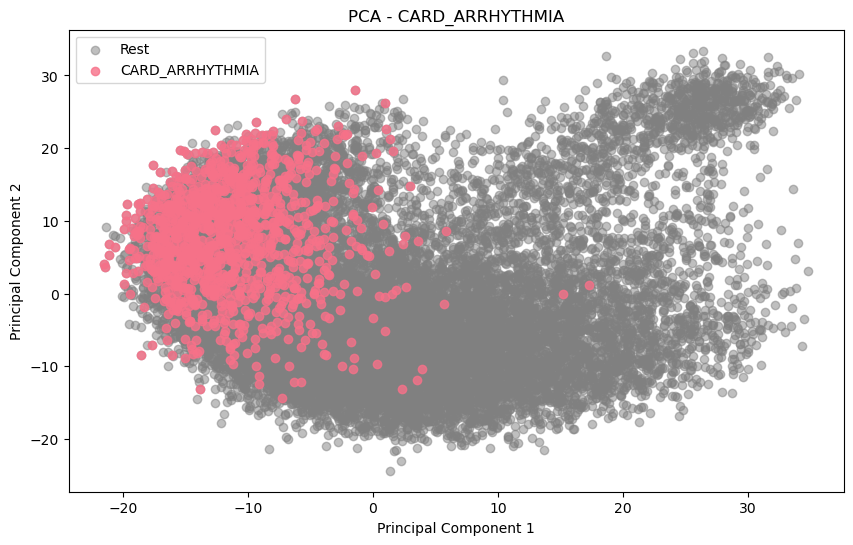

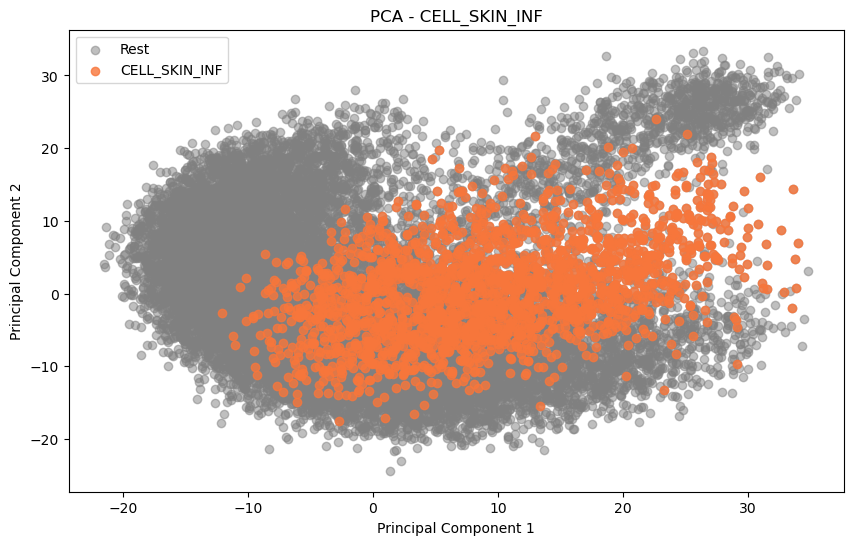

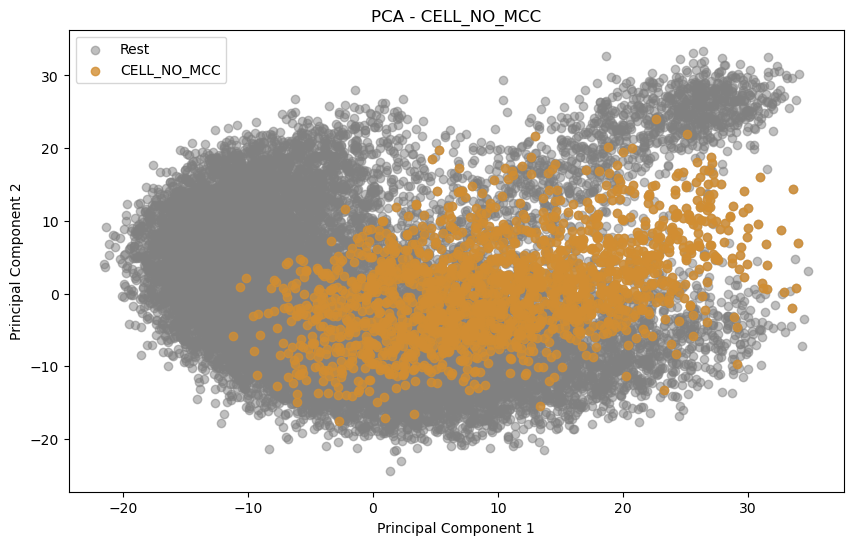

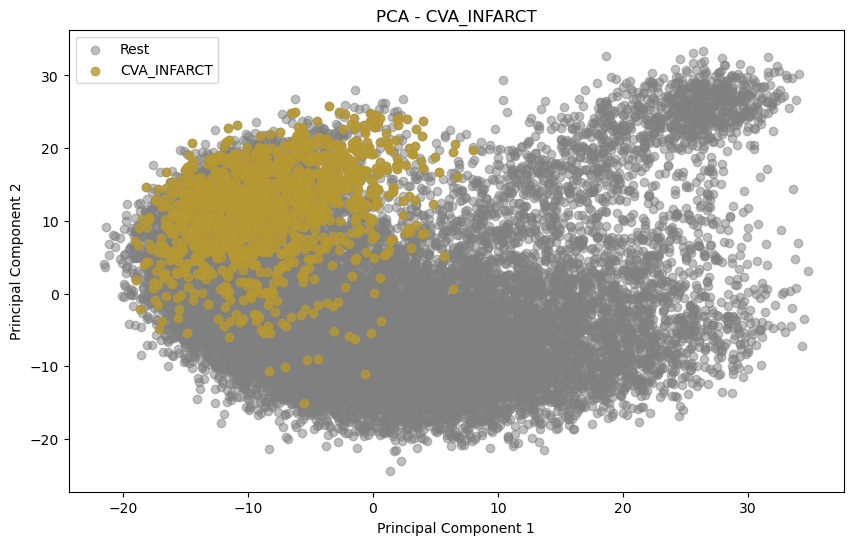

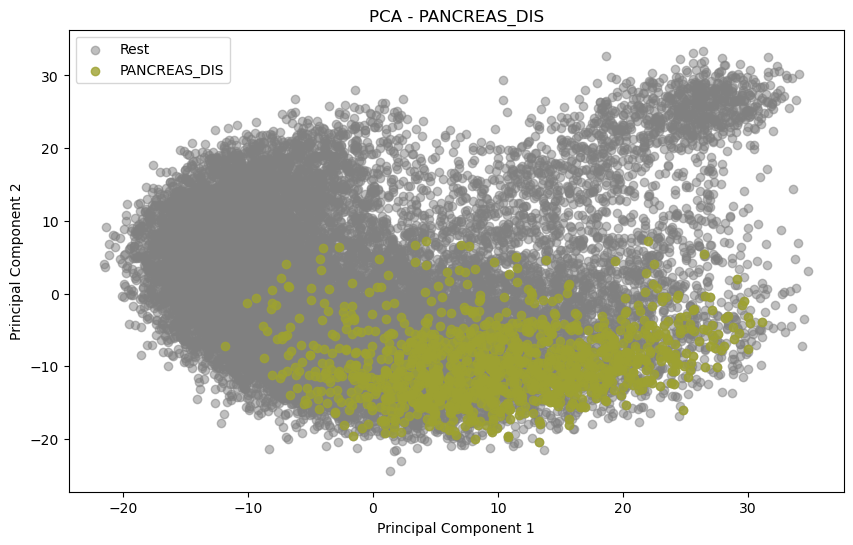

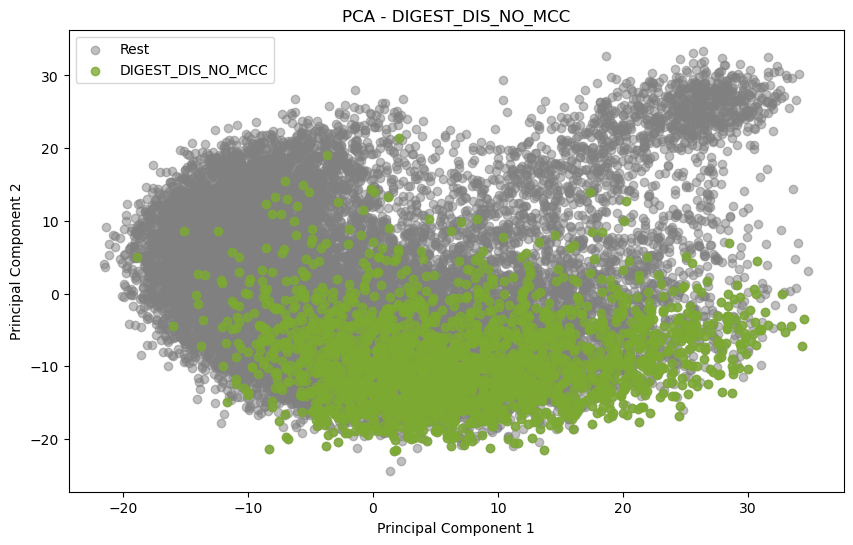

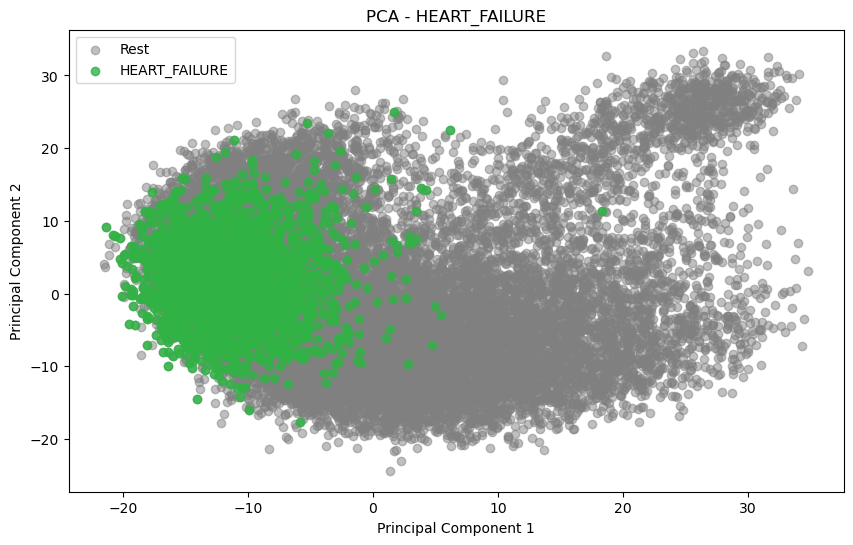

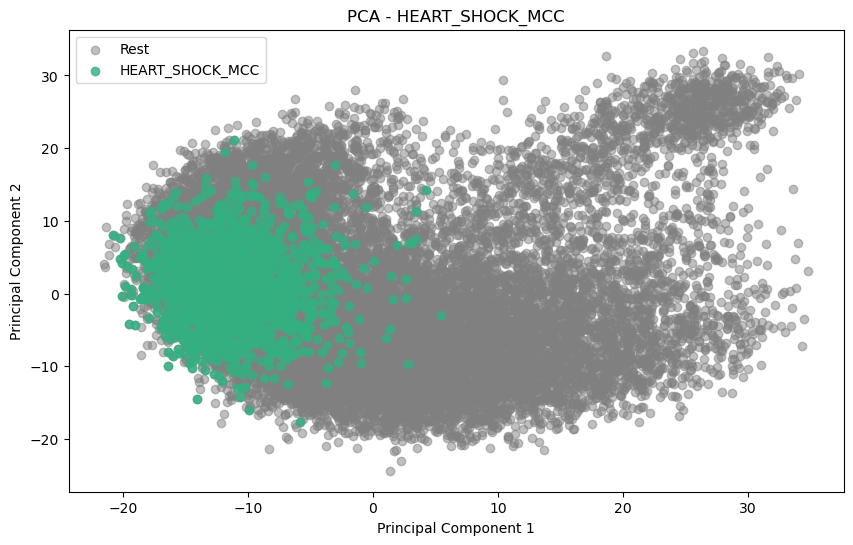

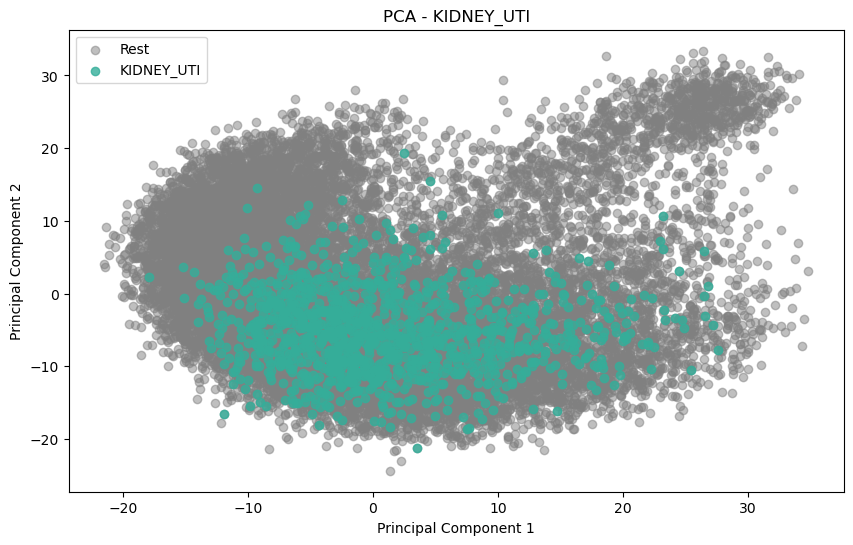

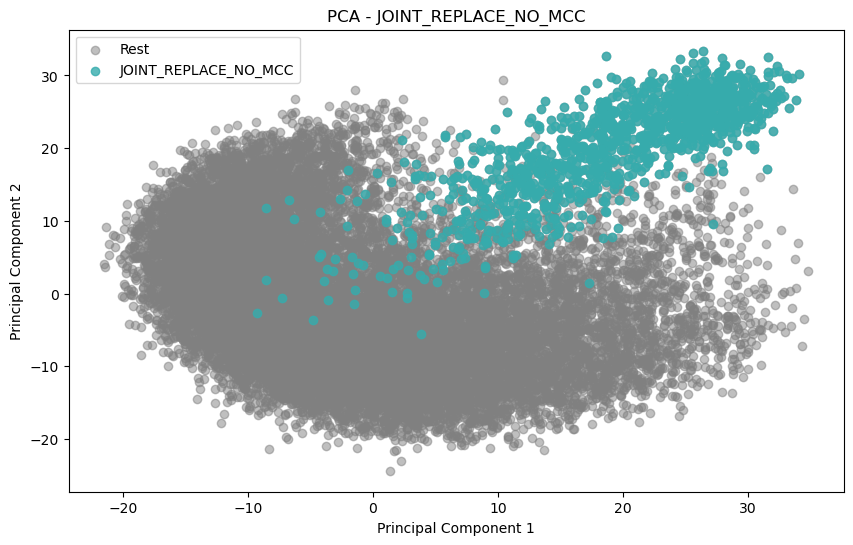

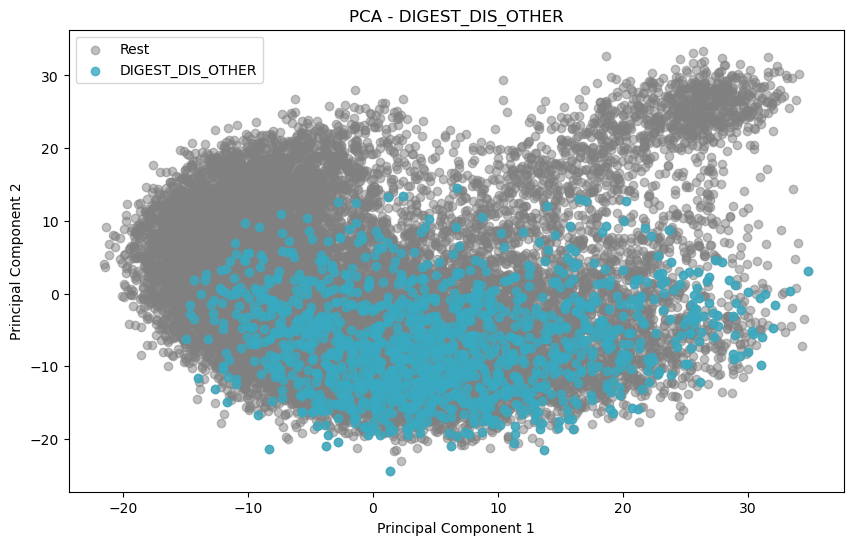

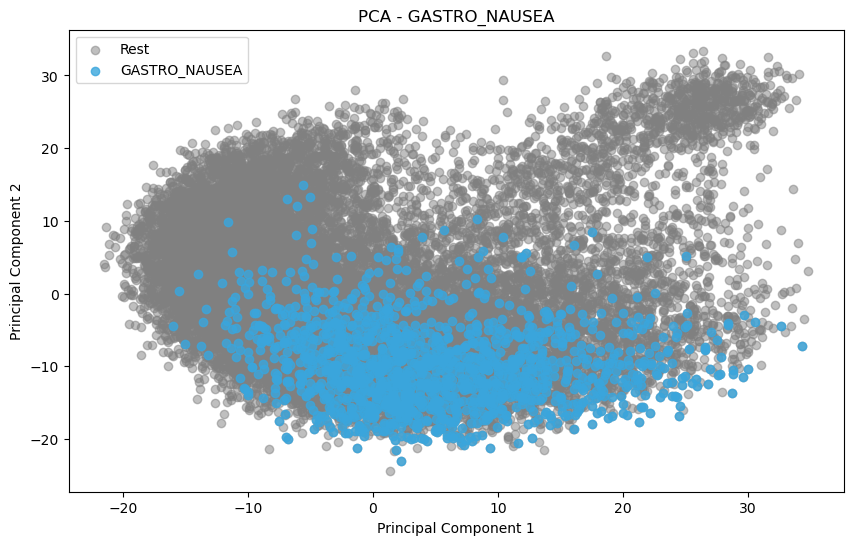

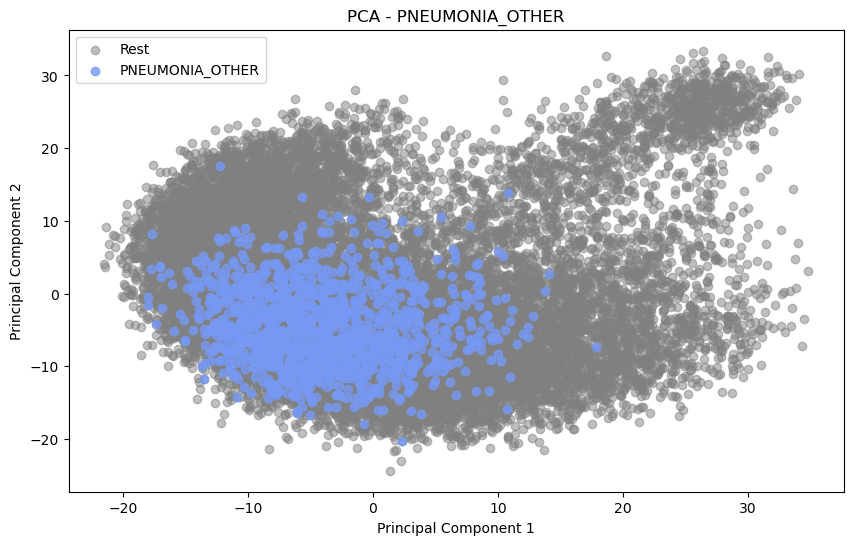

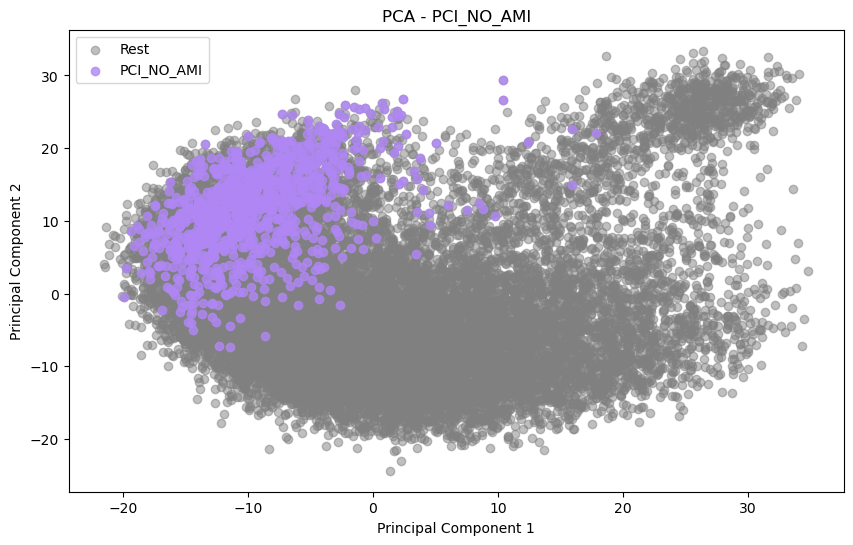

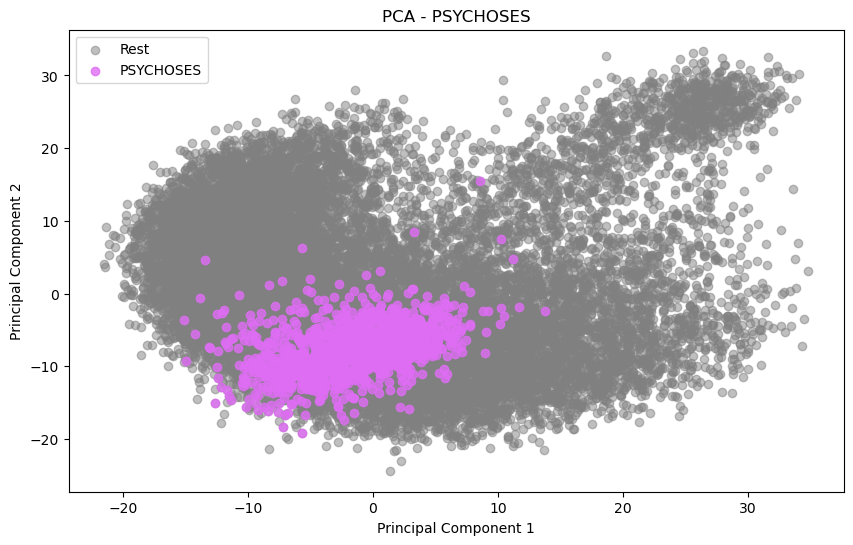

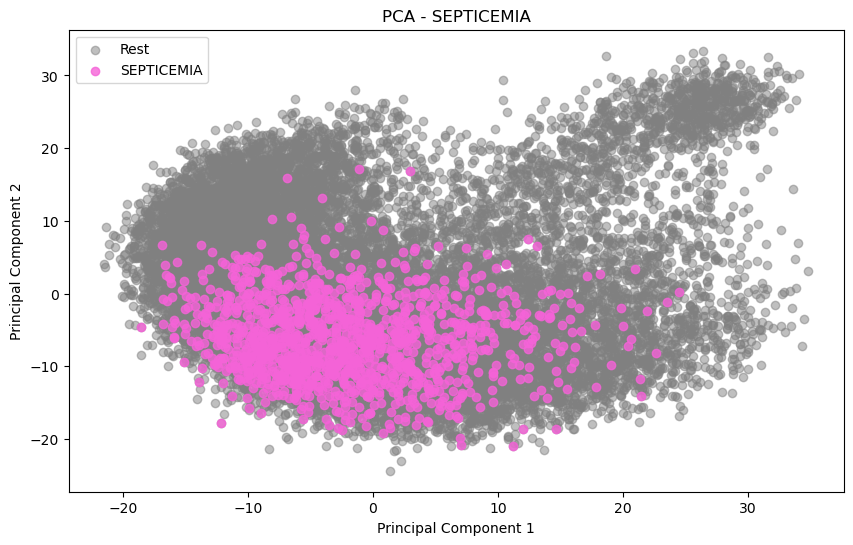

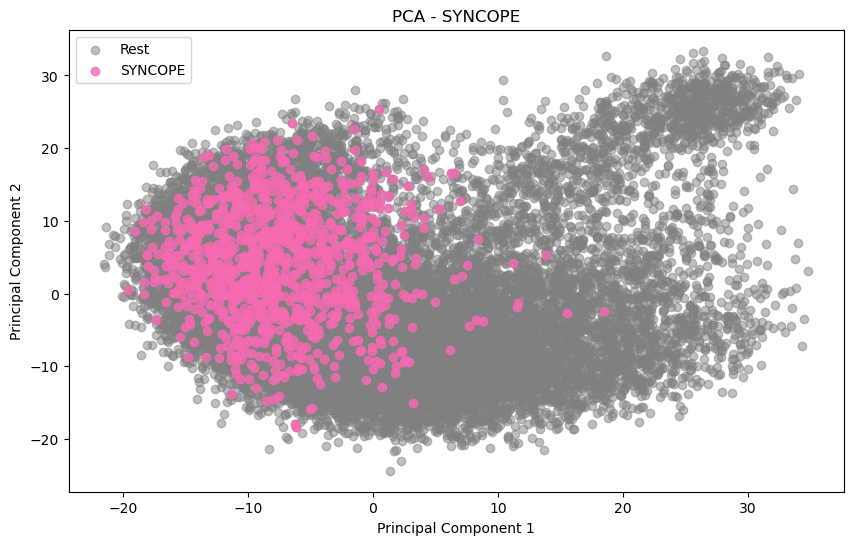

In [34]:
import seaborn as sns

diagnosis_columns = class_columns
colors = sns.color_palette('husl', len(diagnosis_columns))


# Function to create PCA plot for a specific diagnosis
def plot_pca_for_diagnosis(pca_df, diagnosis_col, color):
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = pca_df[diagnosis_col] == 1
    plt.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], color=color, alpha=0.8, label=diagnosis_col)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA - {diagnosis_col}')
    plt.legend()
    plt.show()

# Loop through each diagnosis and create a plot
for diagnosis_col, color in zip(diagnosis_columns, colors):
    plot_pca_for_diagnosis(pca_df, diagnosis_col, color)

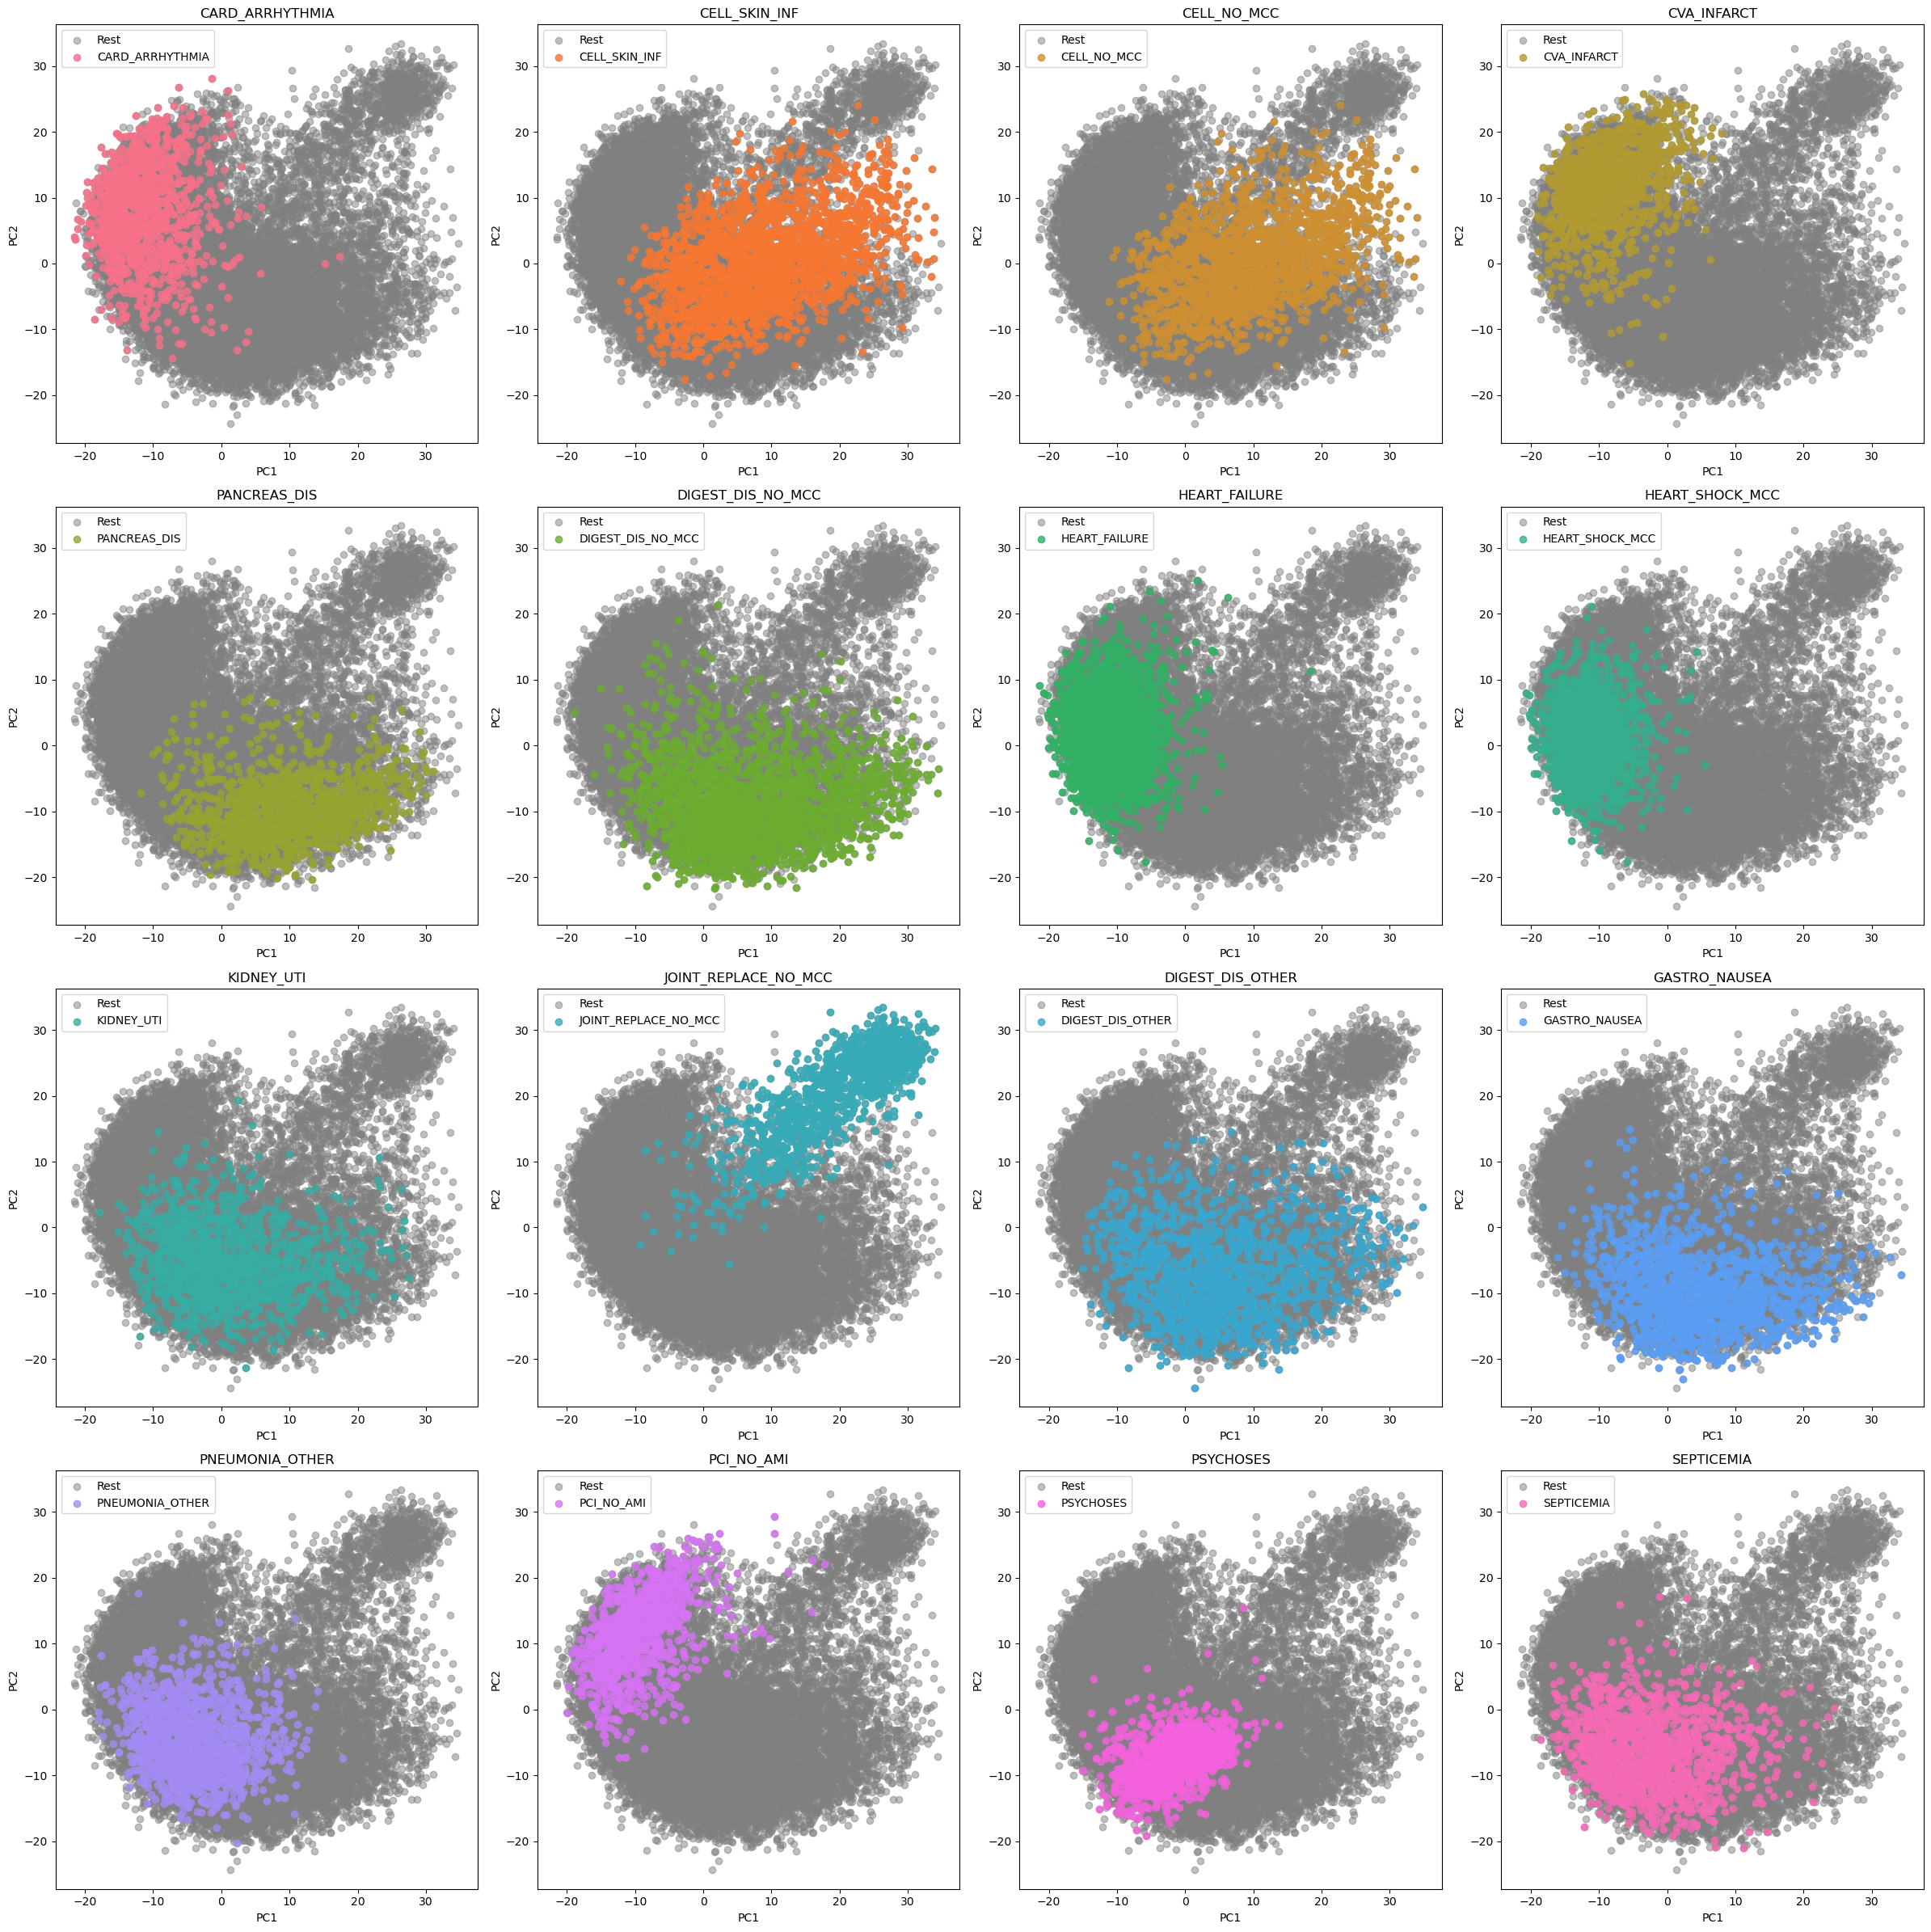

In [35]:

# Define unique colors for each diagnosis
diagnosis_columns = class_columns[:-1]  # Drop the last class to make it 16 diagnoses
colors = sns.color_palette('husl', len(diagnosis_columns))

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(24, 24))
axes = axes.flatten()

# Function to create PCA plot for a specific diagnosis on a given axis
def plot_pca_for_diagnosis(pca_df, diagnosis_col, color, ax):
    ax.scatter(pca_df['PC1'], pca_df['PC2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = pca_df[diagnosis_col] == 1
    ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each diagnosis and create a plot on the respective axis
for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
    plot_pca_for_diagnosis(pca_df, diagnosis_col, color, ax)

# Adjust layout
plt.tight_layout()
plt.show()

In [36]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 53.0 MB/s eta 0:00:0000:0100:01


In [41]:
import umap

# Perform UMAP
umap_reducer = umap.UMAP(n_components=2, n_jobs=-1)
umap_embedding = umap_reducer.fit_transform(embeddings_standardized)

# Create a DataFrame with the UMAP results
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df = pd.concat([umap_df, merge_df[diagnosis_columns].reset_index(drop=True)], axis=1)
umap_df


UMAP1     UMAP2  CARD_ARRHYTHMIA  CELL_SKIN_INF  CELL_NO_MCC  \
0      -1.108861 -2.295280                0              0            0   
1      -1.272377 -2.556664                0              0            0   
2      -1.734334 -5.194922                0              0            0   
3      -3.652407  0.106589                0              0            0   
4      -1.603414 -2.396644                0              0            0   
...          ...       ...              ...            ...          ...   
19579  11.640025  2.485298                0              0            0   
19580  -1.534810  1.899981                0              0            0   
19581  -1.725058 -5.611598                0              0            0   
19582   0.480075 -1.067314                0              0            0   
19583   2.530452 -4.622064                0              0            0   

       CVA_INFARCT  PANCREAS_DIS  DIGEST_DIS_NO_MCC  HEART_FAILURE  \
0                0             0                  0              1   
1                0             0                  0              1   
2                0             0                  0              0   
3                0             0                  0              0   
4                0             0                  0              1   
...            ...           ...                ...            ...   
19579            0             0                  0              0   
19580            0             0                  0              0   
19581            0             0                  0              0   
19582            0             0                  0              0   
19583            1             0                  0              0   

       HEART_SHOCK_MCC  KIDNEY_UTI  JOINT_REPLACE_NO_MCC  DIGEST_DIS_OTHER  \
0                    0           0                     0                 0   
1                    1           0                     0                 0   
2                    0           0                     0                 0   
3                    0           0                     0                 0   
4                    1           0                     0                 0   
...                ...         ...                   ...               ...   
19579                0           0                     1                 0   
19580                0           0                     0                 1   
19581                0           0                     0                 0   
19582                0           0                     0                 0   
19583                0           0                     0                 0   

       GASTRO_NAUSEA  PNEUMONIA_OTHER  PCI_NO_AMI  PSYCHOSES  SEPTICEMIA  
0                  0                0           0          0           0  
1                  0                0           0          0           0  
2                  0                0           1          0           0  
3                  0                1           0          0           0  
4                  0                0           0          0           0  
...              ...              ...         ...        ...         ...  
19579              0                0           0          0           0  
19580              0                0           0          0           0  
19581              0                0           1          0           0  
19582              0                1           0          0           0  
19583              0                0           0          0           0  

[19584 rows x 18 columns]

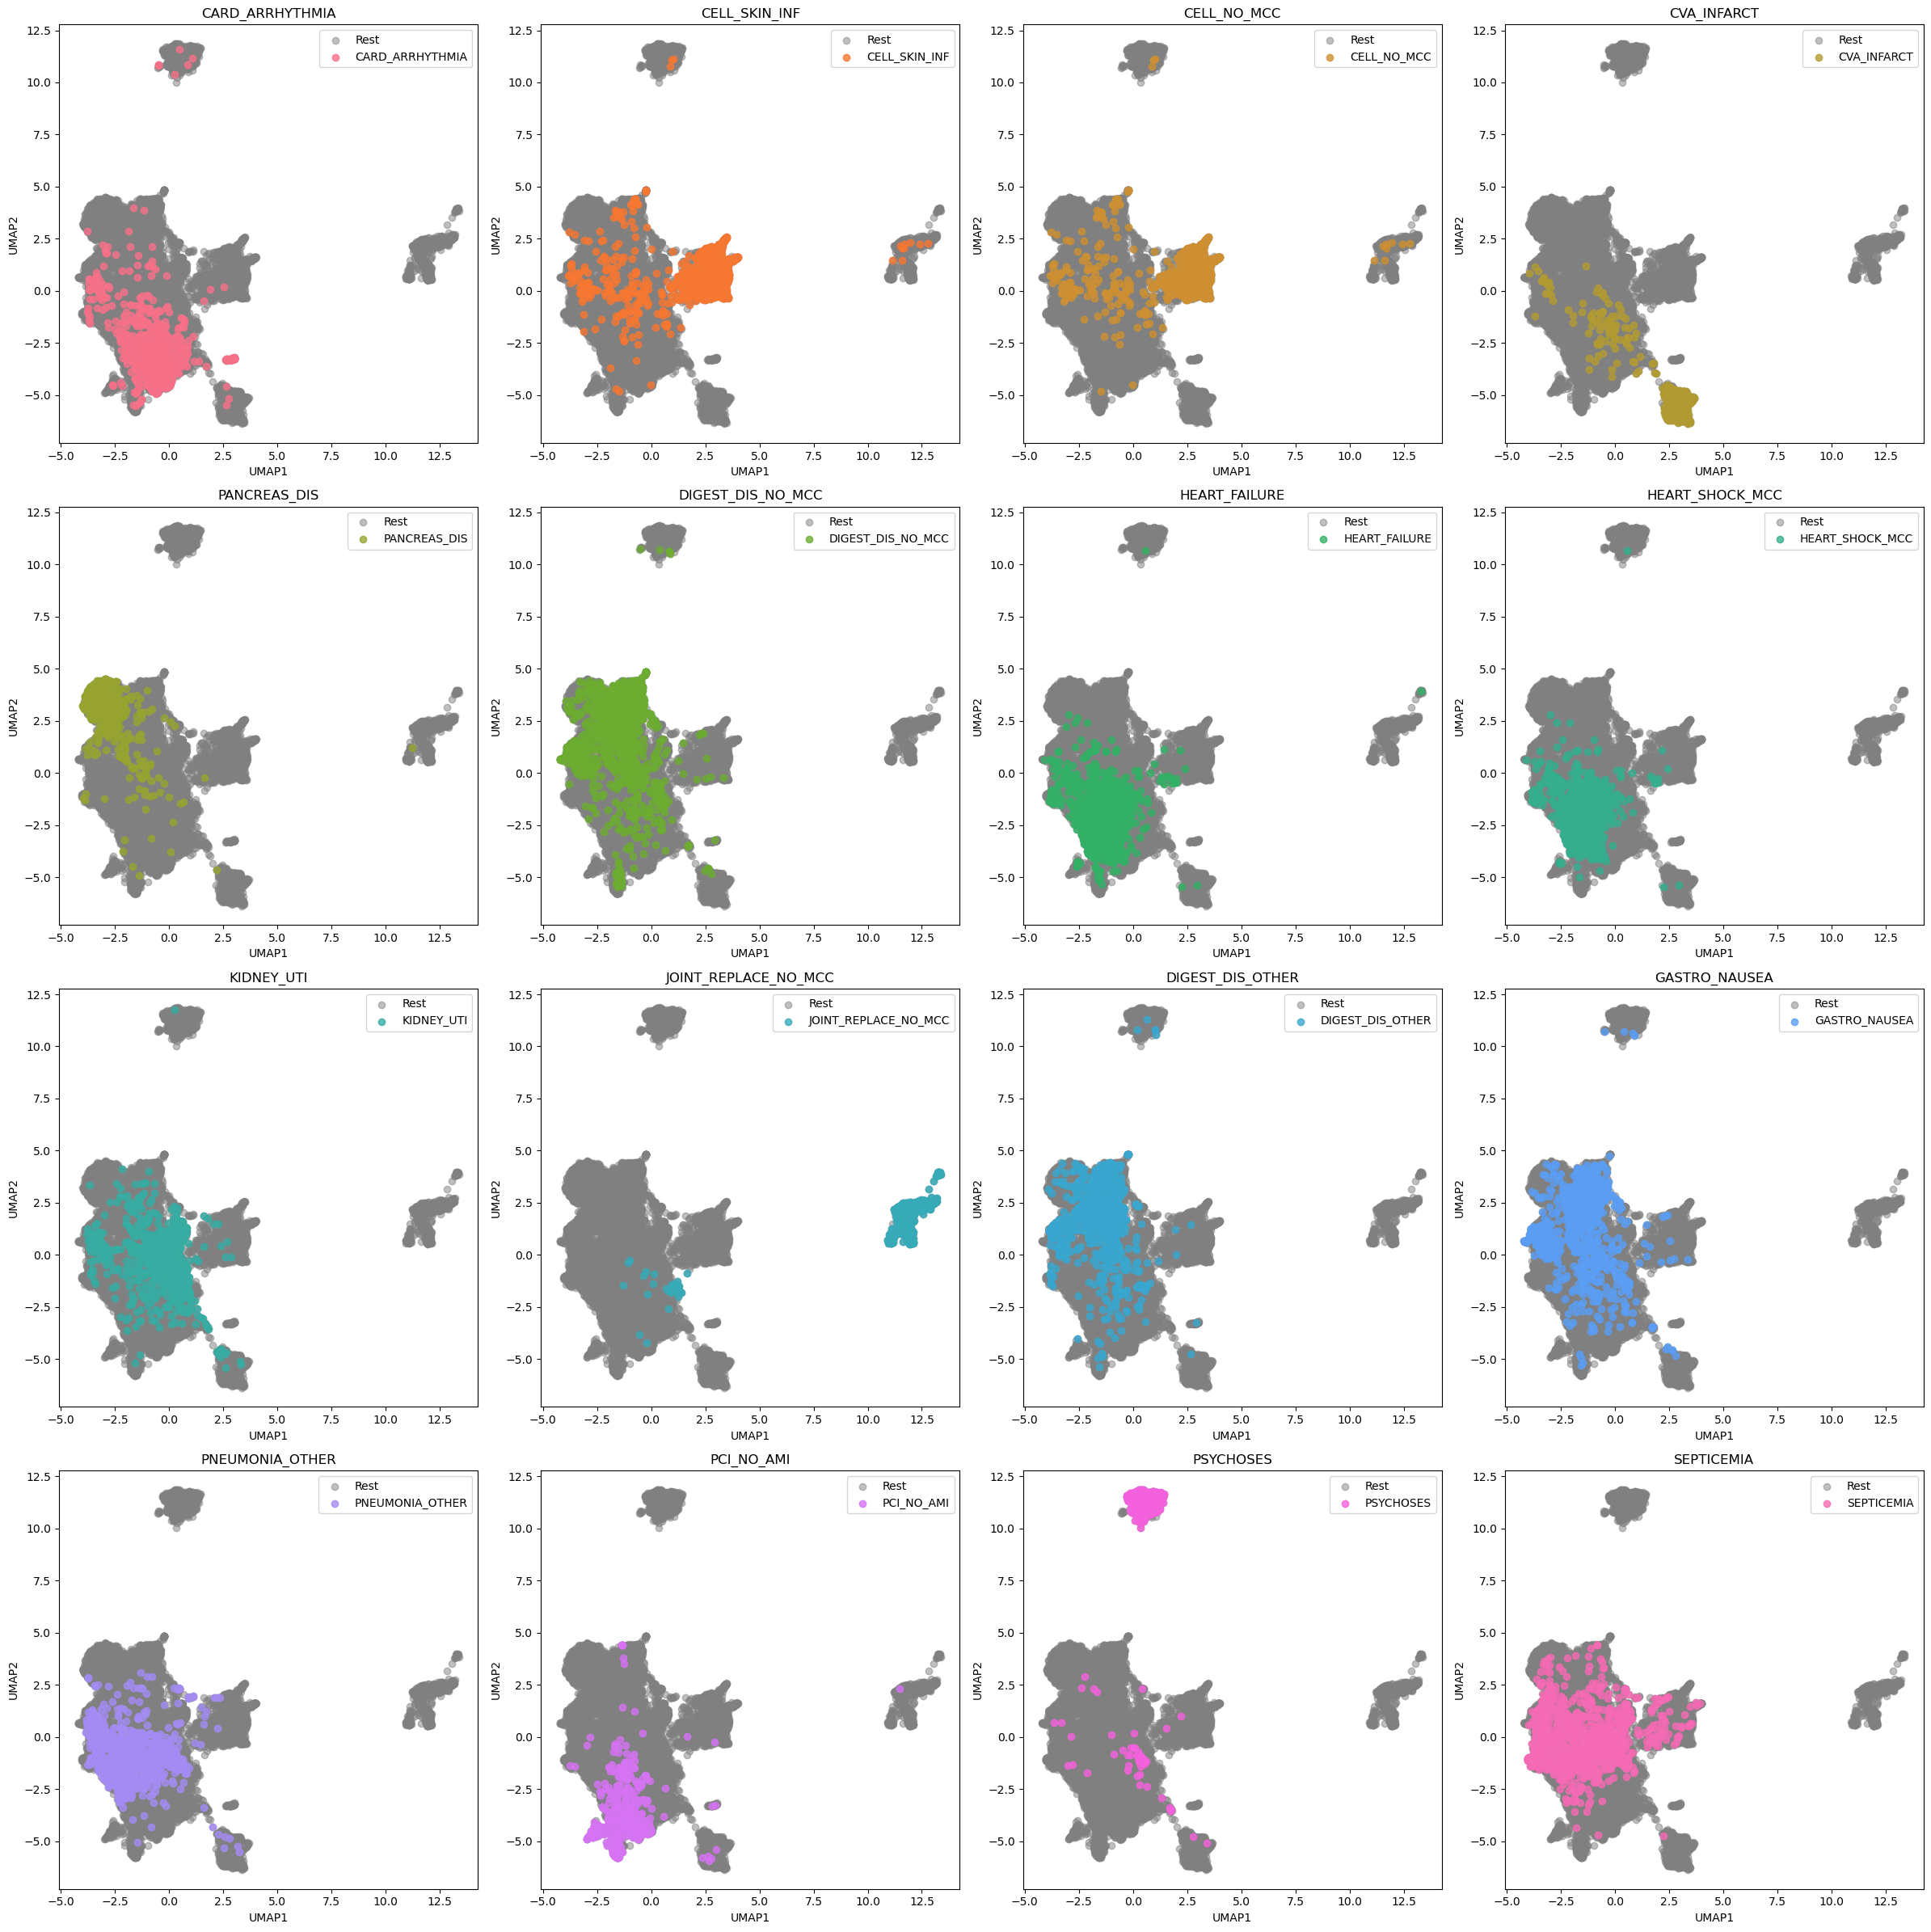

In [42]:
colors = sns.color_palette('husl', len(diagnosis_columns))


# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(24, 24))
axes = axes.flatten()

# Function to create UMAP plot for a specific diagnosis on a given axis
def plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax):
    ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = umap_df[diagnosis_col] == 1
    ax.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each diagnosis and create a plot on the respective axis
for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
    plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax)

# Adjust layout
plt.tight_layout()
plt.show()

In [45]:

output_dir = 'embedding_umap'
os.makedirs(output_dir, exist_ok=True)

# Define different UMAP hyperparameter configurations to try
umap_params = [
    {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 2, 'metric': 'euclidean'},
    {'n_neighbors': 30, 'min_dist': 0.1, 'n_components': 2, 'metric': 'euclidean'},
    {'n_neighbors': 15, 'min_dist': 0.5, 'n_components': 2, 'metric': 'euclidean'},
    {'n_neighbors': 30, 'min_dist': 0.5, 'n_components': 2, 'metric': 'euclidean'}
]

# Function to create UMAP plot for a specific diagnosis on a given axis
def plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax):
    ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = umap_df[diagnosis_col] == 1
    ax.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each set of UMAP hyperparameters and create a separate grid of plots
for param_idx, params in enumerate(umap_params):
    # Perform UMAP
    umap_reducer = umap.UMAP(n_neighbors=params['n_neighbors'], min_dist=params['min_dist'], 
                             n_components=params['n_components'], metric=params['metric'], n_jobs=-1)
    umap_embedding = umap_reducer.fit_transform(embeddings_standardized)
    
    # Create a DataFrame with the UMAP results
    umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
    umap_df = pd.concat([umap_df, merge_df[diagnosis_columns].reset_index(drop=True)], axis=1)
    
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    axes = axes.flatten()
    
    # Loop through each diagnosis and create a plot on the respective axis
    for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
        plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax)
    
    # Adjust layout
    plt.tight_layout()
    plt.suptitle(f'UMAP with n_neighbors={params["n_neighbors"]}, min_dist={params["min_dist"]}', y=1.02)
    filename = f'umap_nneighbors{params["n_neighbors"]}_mindist{params["min_dist"]}.png'
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig)

In [50]:
from itertools import product

output_dir = 'embedding_umap'
os.makedirs(output_dir, exist_ok=True)

# Define the range of hyperparameter values to try
n_neighbors_values = [5, 10, 20, 40]
min_dist_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Generate all combinations of hyperparameters
umap_params = list(product(n_neighbors_values, min_dist_values))

# Function to create UMAP plot for a specific diagnosis on a given axis
def plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax):
    ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = umap_df[diagnosis_col] == 1
    ax.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each set of UMAP hyperparameters and create a separate grid of plots
for param_idx, (n_neighbors, min_dist) in enumerate(umap_params):
    # Perform UMAP
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, n_jobs=-1)
    umap_embedding = umap_reducer.fit_transform(embeddings_standardized)
    
    # Create a DataFrame with the UMAP results
    umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
    umap_df = pd.concat([umap_df, merge_df[diagnosis_columns].reset_index(drop=True)], axis=1)
    
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    axes = axes.flatten()
    
    # Loop through each diagnosis and create a plot on the respective axis
    for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
        plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax)
    
    # Adjust layout
    plt.tight_layout()
    plt.suptitle(f'UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}', y=1.02)
    filename = f'umap_nneighbors{n_neighbors}_mindist{min_dist}.png'
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig)

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from itertools import product

# Assuming you have your dataframe named `merge_df` and standardized embeddings `embeddings_standardized`

output_dir = 'embedding_umap'
os.makedirs(output_dir, exist_ok=True)

# Define the range of hyperparameter values to try
n_neighbors_values = [15, 30, 50]
min_dist_values = [0.1, 0.3, 0.5]
spread_values = [1.0, 2.0, 3.0]

# Generate all combinations of hyperparameters
umap_params = list(product(n_neighbors_values, min_dist_values, spread_values))

# Define unique colors for each diagnosis
diagnosis_columns = merge_df.columns[4:20]  # Adjust based on your actual diagnosis columns, dropping the last class for a 4x4 grid
colors = sns.color_palette('husl', len(diagnosis_columns))

# Function to create UMAP plot for a specific diagnosis on a given axis
def plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax):
    ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = umap_df[diagnosis_col] == 1
    ax.scatter(umap_df.loc[mask, 'UMAP1'], umap_df.loc[mask, 'UMAP2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each set of UMAP hyperparameters and create a separate grid of plots
for param_idx, (n_neighbors, min_dist, spread) in enumerate(umap_params):
    # Perform UMAP
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, spread=spread,
                             n_components=2, metric='euclidean', n_jobs=-1)
    umap_embedding = umap_reducer.fit_transform(embeddings_standardized)
    
    # Create a DataFrame with the UMAP results
    umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
    umap_df = pd.concat([umap_df, merge_df[diagnosis_columns].reset_index(drop=True)], axis=1)
    
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    axes = axes.flatten()
    
    # Loop through each diagnosis and create a plot on the respective axis
    for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
        plot_umap_for_diagnosis(umap_df, diagnosis_col, color, ax)
    
    # Adjust layout
    plt.tight_layout()
    plt.suptitle(f'UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}', y=1.02)
    filename = f'umap_nneighbors{n_neighbors}_mindist{min_dist}_spread{spread}.png'
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig)


In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Assuming you have your dataframe named `merge_df` and standardized embeddings `embeddings_standardized`

output_dir = 'embedding_tsne'
os.makedirs(output_dir, exist_ok=True)

# Define different t-SNE hyperparameter configurations to try
tsne_params = [
    {'perplexity': 5, 'learning_rate': 250, 'n_components': 2},
    {'perplexity': 10, 'learning_rate': 250, 'n_components': 2},
    {'perplexity': 25, 'learning_rate': 250, 'n_components': 2},
    {'perplexity': 50, 'learning_rate': 250, 'n_components': 2}
]

# Define unique colors for each diagnosis
diagnosis_columns = merge_df.columns[4:20]  # Adjust based on your actual diagnosis columns, dropping the last class for a 4x4 grid
colors = sns.color_palette('husl', len(diagnosis_columns))

# Function to create t-SNE plot for a specific diagnosis on a given axis
def plot_tsne_for_diagnosis(tsne_df, diagnosis_col, color, ax):
    ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = tsne_df[diagnosis_col] == 1
    ax.scatter(tsne_df.loc[mask, 'TSNE1'], tsne_df.loc[mask, 'TSNE2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('TSNE1')
    ax.set_ylabel('TSNE2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each set of t-SNE hyperparameters and create a separate grid of plots
for param_idx, params in enumerate(tsne_params):
    # Perform t-SNE
    tsne = TSNE(n_components=params['n_components'], perplexity=params['perplexity'], 
                learning_rate=params['learning_rate'], n_jobs=-1)
    tsne_embedding = tsne.fit_transform(embeddings_standardized)
    
    # Create a DataFrame with the t-SNE results
    tsne_df = pd.DataFrame(tsne_embedding, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.concat([tsne_df, merge_df[diagnosis_columns].reset_index(drop=True)], axis=1)
    
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    axes = axes.flatten()
    
    # Loop through each diagnosis and create a plot on the respective axis
    for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
        plot_tsne_for_diagnosis(tsne_df, diagnosis_col, color, ax)
    
    # Adjust layout and save figure
    plt.tight_layout()
    plt.suptitle(f't-SNE with perplexity={params["perplexity"]}, learning_rate={params["learning_rate"]}', y=1.02)
    filename = f'tsne_perplexity{params["perplexity"]}_learningrate{params["learning_rate"]}.png'
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig)


In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Assuming you have your dataframe named `merge_df` and standardized embeddings `embeddings_standardized`

output_dir = 'embedding_tsne'
os.makedirs(output_dir, exist_ok=True)

# Define different t-SNE hyperparameter configurations to try
tsne_params = [
    {'perplexity': 30, 'learning_rate': 200, 'n_components': 2},
    {'perplexity': 50, 'learning_rate': 200, 'n_components': 2},
    {'perplexity': 30, 'learning_rate': 500, 'n_components': 2},
    {'perplexity': 50, 'learning_rate': 500, 'n_components': 2},
    {'perplexity': 100, 'learning_rate': 'auto', 'n_components': 2},
]

# Define unique colors for each diagnosis
diagnosis_columns = merge_df.columns[4:20]  # Adjust based on your actual diagnosis columns, dropping the last class for a 4x4 grid
colors = sns.color_palette('husl', len(diagnosis_columns))

# Function to create t-SNE plot for a specific diagnosis on a given axis
def plot_tsne_for_diagnosis(tsne_df, diagnosis_col, color, ax):
    ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = tsne_df[diagnosis_col] == 1
    ax.scatter(tsne_df.loc[mask, 'TSNE1'], tsne_df.loc[mask, 'TSNE2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('TSNE1')
    ax.set_ylabel('TSNE2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each set of t-SNE hyperparameters and create a separate grid of plots
for param_idx, params in enumerate(tsne_params):
    # Perform t-SNE
    tsne = TSNE(n_components=params['n_components'], perplexity=params['perplexity'], 
                learning_rate=params['learning_rate'], n_jobs=-1)
    tsne_embedding = tsne.fit_transform(embeddings_standardized)
    
    # Create a DataFrame with the t-SNE results
    tsne_df = pd.DataFrame(tsne_embedding, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.concat([tsne_df, merge_df[diagnosis_columns].reset_index(drop=True)], axis=1)
    
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    axes = axes.flatten()
    
    # Loop through each diagnosis and create a plot on the respective axis
    for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
        plot_tsne_for_diagnosis(tsne_df, diagnosis_col, color, ax)
    
    # Adjust layout and save figure
    plt.tight_layout()
    plt.suptitle(f't-SNE with perplexity={params["perplexity"]}, learning_rate={params["learning_rate"]}', y=1.02)
    filename = f'tsne_perplexity{params["perplexity"]}_learningrate{params["learning_rate"]}.png'
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig)


In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Assuming you have your dataframe named `merge_df` and standardized embeddings `embeddings_standardized`

output_dir = 'embedding_tsne'
os.makedirs(output_dir, exist_ok=True)

# Define different t-SNE hyperparameter configurations to try
tsne_params = [
    {'perplexity': 30, 'learning_rate': 'auto', 'early_exaggeration': 12, 'n_components': 2},
    {'perplexity': 30, 'learning_rate': 'auto', 'early_exaggeration': 16, 'n_components': 2},
    {'perplexity': 30, 'learning_rate': 'auto', 'early_exaggeration': 24, 'n_components': 2},
    {'perplexity': 30, 'learning_rate': 'auto', 'early_exaggeration': 32, 'n_components': 2},
]

# Define unique colors for each diagnosis
diagnosis_columns = merge_df.columns[4:20]  # Adjust based on your actual diagnosis columns, dropping the last class for a 4x4 grid
colors = sns.color_palette('husl', len(diagnosis_columns))

# Function to create t-SNE plot for a specific diagnosis on a given axis
def plot_tsne_for_diagnosis(tsne_df, diagnosis_col, color, ax):
    ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], color='gray', alpha=0.5, label='Rest')
    
    # Highlight rows with the specific diagnosis
    mask = tsne_df[diagnosis_col] == 1
    ax.scatter(tsne_df.loc[mask, 'TSNE1'], tsne_df.loc[mask, 'TSNE2'], color=color, alpha=0.8, label=diagnosis_col)
    
    ax.set_xlabel('TSNE1')
    ax.set_ylabel('TSNE2')
    ax.set_title(diagnosis_col)
    ax.legend()

# Loop through each set of t-SNE hyperparameters and create a separate grid of plots
for param_idx, params in enumerate(tsne_params):
    # Perform t-SNE
    tsne = TSNE(n_components=params['n_components'], perplexity=params['perplexity'], 
                learning_rate=params['learning_rate'], early_exaggeration=params['early_exaggeration'], n_jobs=-1)
    tsne_embedding = tsne.fit_transform(embeddings_standardized)
    
    # Create a DataFrame with the t-SNE results
    tsne_df = pd.DataFrame(tsne_embedding, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.concat([tsne_df, merge_df[diagnosis_columns].reset_index(drop=True)], axis=1)
    
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    axes = axes.flatten()
    
    # Loop through each diagnosis and create a plot on the respective axis
    for ax, (diagnosis_col, color) in zip(axes, zip(diagnosis_columns, colors)):
        plot_tsne_for_diagnosis(tsne_df, diagnosis_col, color, ax)
    
    # Adjust layout and save figure
    plt.tight_layout()
    plt.suptitle(f't-SNE with perplexity={params["perplexity"]}, learning_rate={params["learning_rate"]}, early_exaggeration={params["early_exaggeration"]}', y=1.02)
    filename = f'tsne_perp{params["perplexity"]}_lr{params["learning_rate"]}_earlyexag{params["early_exaggeration"]}.png'
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig)
